# Final Project

`Target:`  Identification model for raccoon and kangaroo    
`Ref:` Day041   

#### Dataset
 * [Kangaroo](https://github.com/experiencor/kangaroo)
 * [Raccoon](https://github.com/experiencor/raccoon_dataset)





In [1]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.0


In [2]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 7.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [3]:
!nvidia-smi

Mon Mar  2 22:21:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [5]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/keras-yolo3


In [6]:
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


In [7]:
# 將資料集格式轉為yolo3的格式
if not os.path.exists("animal.txt"):
    labels = open('dataset/labels.csv', 'r')
    line = labels.readline()
    print(line[:-1].split(','))

    list_file = open('animal.txt', 'w')
    file_name = ''
    file_animal = ''

    while line:
        line = labels.readline()
        if line == '':
            break

        line_messages = line[:-1].split(',')
        print(line_messages)

        if file_name == line_messages[0]:
            list_file.write(' ' + line_messages[4] + ',' + line_messages[5] + ',' + line_messages[6] + ',' + line_messages[7] + ',' + file_animal)
        else:
            if file_name != '':
                list_file.write('\n')

            file_name = line_messages[0]
            if line_messages[3] == 'kangaroo':
                list_file.write('dataset/images/' + file_name + ' ' + line_messages[4] + ',' + line_messages[5] + ',' + line_messages[6] + ',' + line_messages[7] + ',0')
            else:
                list_file.write('dataset/images/' + file_name + ' ' + line_messages[4] + ',' + line_messages[5] + ',' + line_messages[6] + ',' + line_messages[7] + ',1')

    list_file.close()
else:
    print("animal.txt exist")

animal.txt exist


In [8]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


In [0]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [10]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [0]:
annotation_path = 'animal.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/animal_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

In [12]:
is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    print("Create tiny model")
    model = create_tiny_model(input_shape, anchors, num_classes, freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    print("Create model")
    model = create_model(input_shape, anchors, num_classes, freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

Create model













Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(
    log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

In [14]:
# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = int(len(lines) - num_val)
print("total:", int(len(lines)), "val:", num_val, "train:", num_train)

total: 363 val: 36 train: 327


In [15]:
# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(
      data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
      steps_per_epoch=max(1, num_train//batch_size),
      validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
      validation_steps=max(1, num_val//batch_size),
      epochs = 50,
      initial_epoch = 0,
      #callbacks=[logging, checkpoint]
      callbacks=[checkpoint]
      )
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')


Train on 327 samples, val on 36 samples, with batch size 16.


Epoch 1/50
20/20 [==============================] - 172s 9s/step - loss: 3787.0230 - val_loss: 953.8057
Epoch 2/50
20/20 [==============================] - 26s 1s/step - loss: 578.3471 - val_loss: 285.3804
Epoch 3/50
20/20 [==============================] - 26s 1s/step - loss: 248.0261 - val_loss: 170.0768
Epoch 4/50
20/20 [==============================] - 14s 724ms/step - loss: 172.1157 - val_loss: 123.3648
Epoch 5/50
20/20 [==============================] - 25s 1s/step - loss: 136.6660 - val_loss: 111.4969
Epoch 6/50
20/20 [==============================] - 25s 1s/step - loss: 110.2537 - val_loss: 88.4245
Epoch 7/50
20/20 [==============================] - 26s 1s/step - loss: 95.1468 - val_loss: 74.3226
Epoch 8/50
20/20 [==============================] - 25s 1s/step - loss: 81.9774 - val_loss: 71.3225
Epoch 9/50
20/20 [==============================] - 26s 1s/step - loss: 73.3216 - val_loss: 60.8551
Epoch 10/50
20/20 [=

### Verify
Use the snapshot of the example video

In [20]:
!ls ../video_stream

Kangaroo_00s.png  Kangaroo_45s.png  Raccoon_30s.png
Kangaroo_15s.png  Raccoon_00s.png   Raccoon_45s.png
Kangaroo_30s.png  Raccoon_15s.png   Raccoon_60s.png


In [30]:
#model_path=log_dir + 'trained_weights_final.h5'
#model_path=log_dir + 'trained_weights_stage_1.h5'
model_path=log_dir + 'ep048-loss20.487-val_loss19.567.h5'
classes_path = 'model_data/animal_classes.txt'
print(model_path)

logs/000/ep048-loss20.487-val_loss19.567.h5


In [0]:
from PIL import Image
from yolo import YOLO

In [31]:
yolo_model = YOLO(
    model_path=model_path, 
    classes_path=classes_path)

logs/000/ep048-loss20.487-val_loss19.567.h5 model, anchors, and classes loaded.


In [0]:
files = []

for r, d, f in os.walk('../video_stream'):
    for file in f:
        if '.png' in file:
            files.append(os.path.join(r, file))

--- ../video_stream/Raccoon_60s.png ---
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (67, 238) (639, 720)
0.12228451400005724


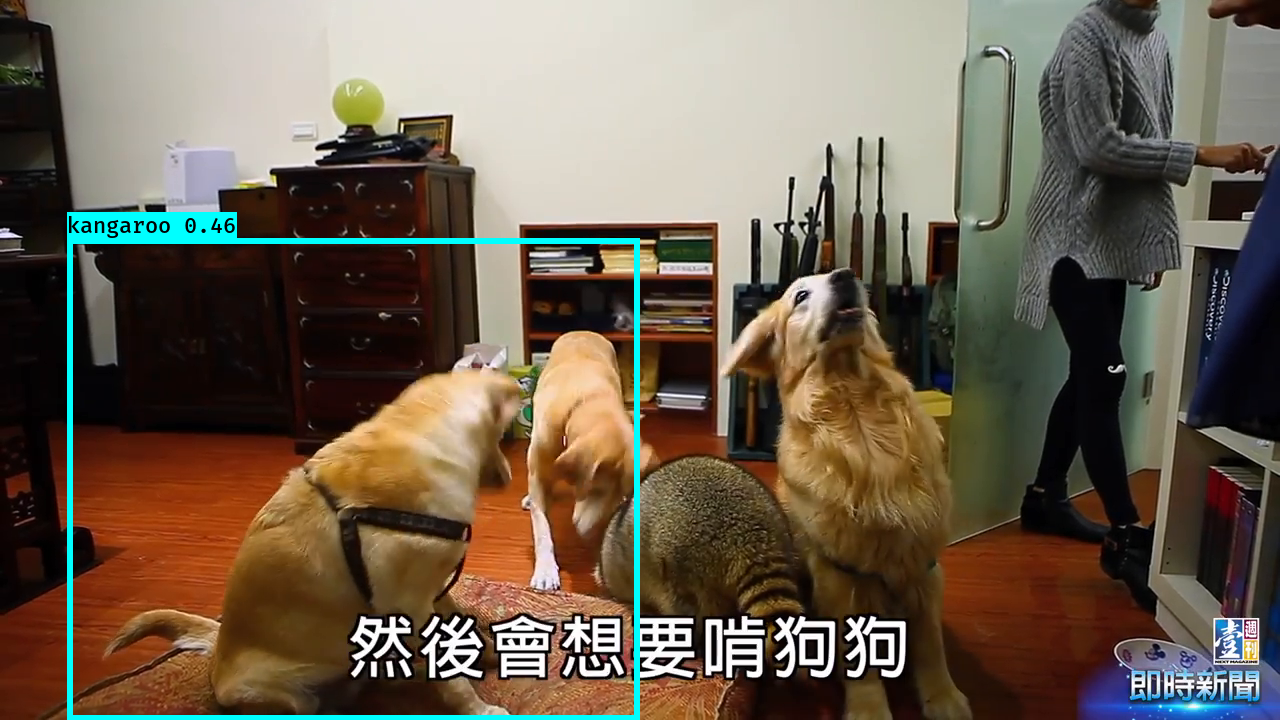

--- ../video_stream/Kangaroo_15s.png ---
(416, 416, 3)
Found 0 boxes for img
0.17878792499959673


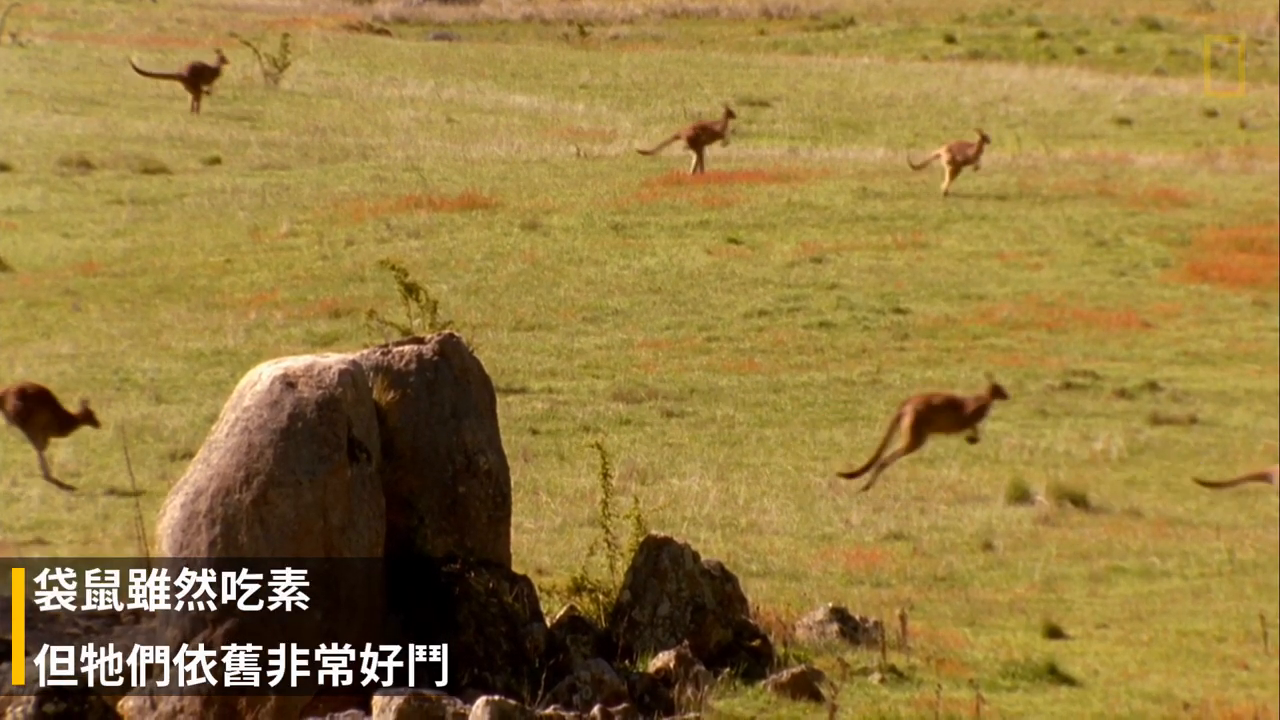

--- ../video_stream/Kangaroo_30s.png ---
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (0, 0) (1280, 720)
0.1379763439999806


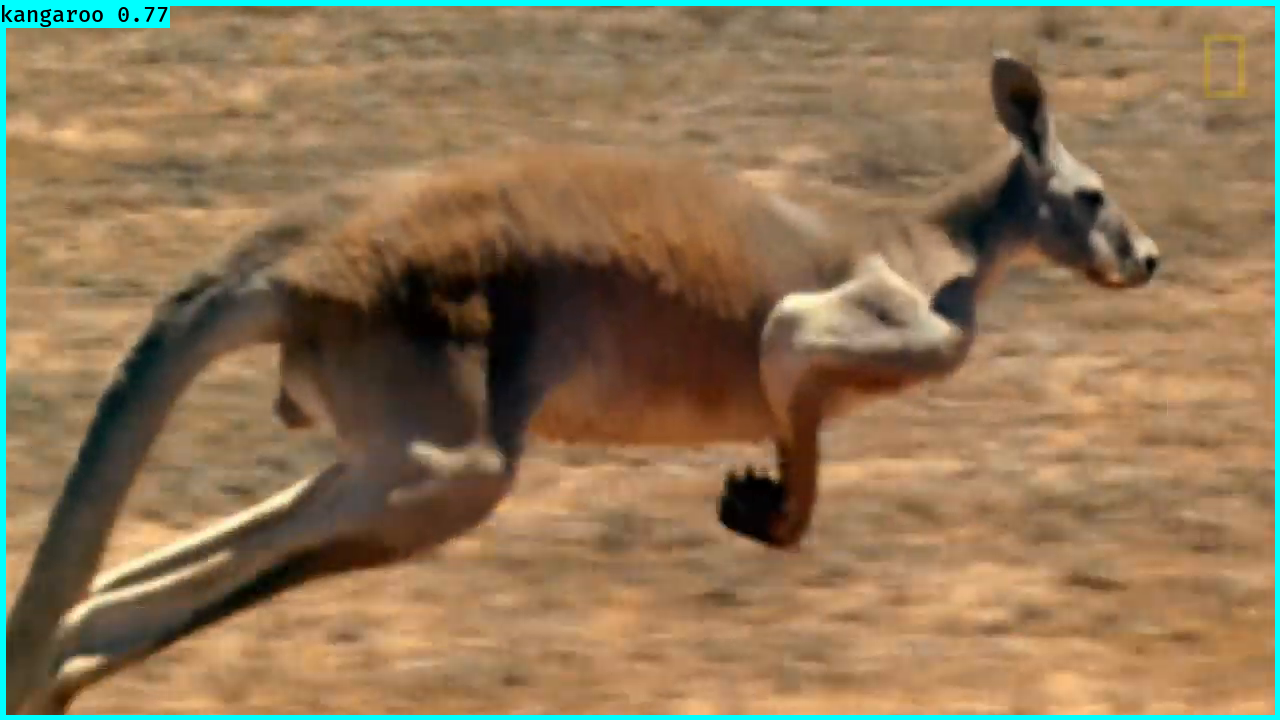

--- ../video_stream/Raccoon_15s.png ---
(416, 416, 3)
Found 0 boxes for img
0.1577114679994338


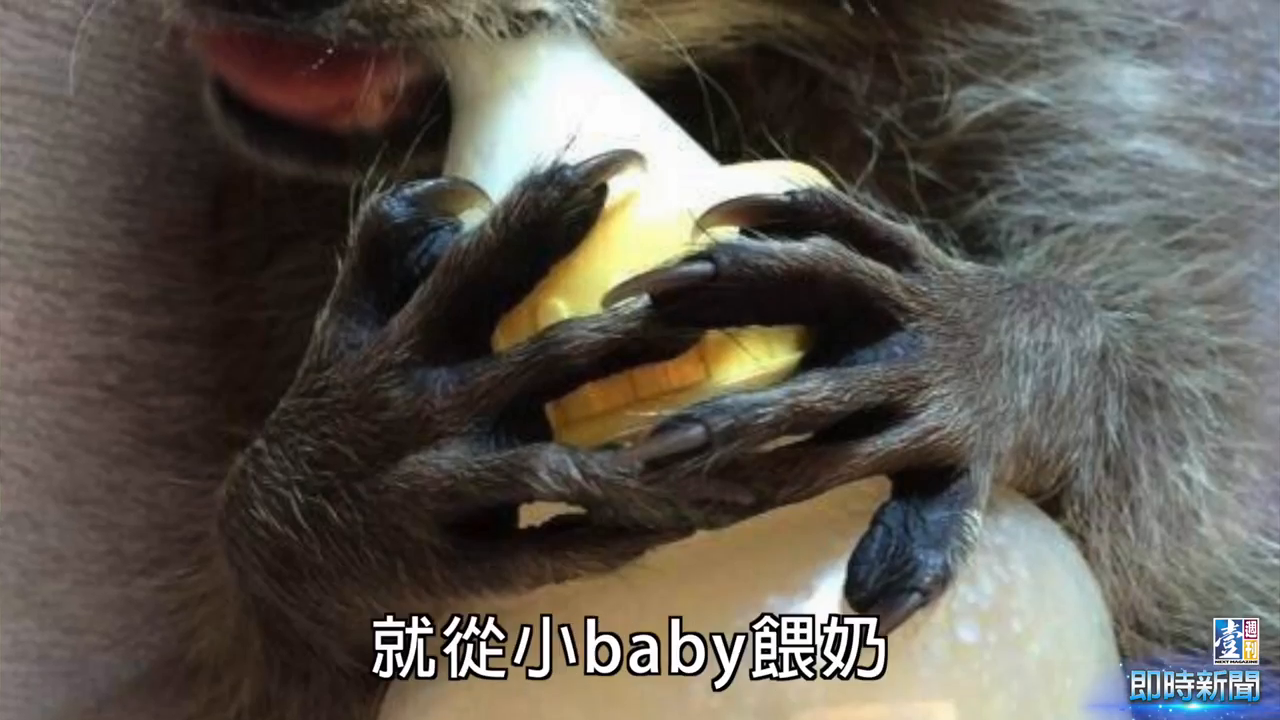

--- ../video_stream/Raccoon_30s.png ---
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (231, 0) (907, 680)
0.13964694800051802


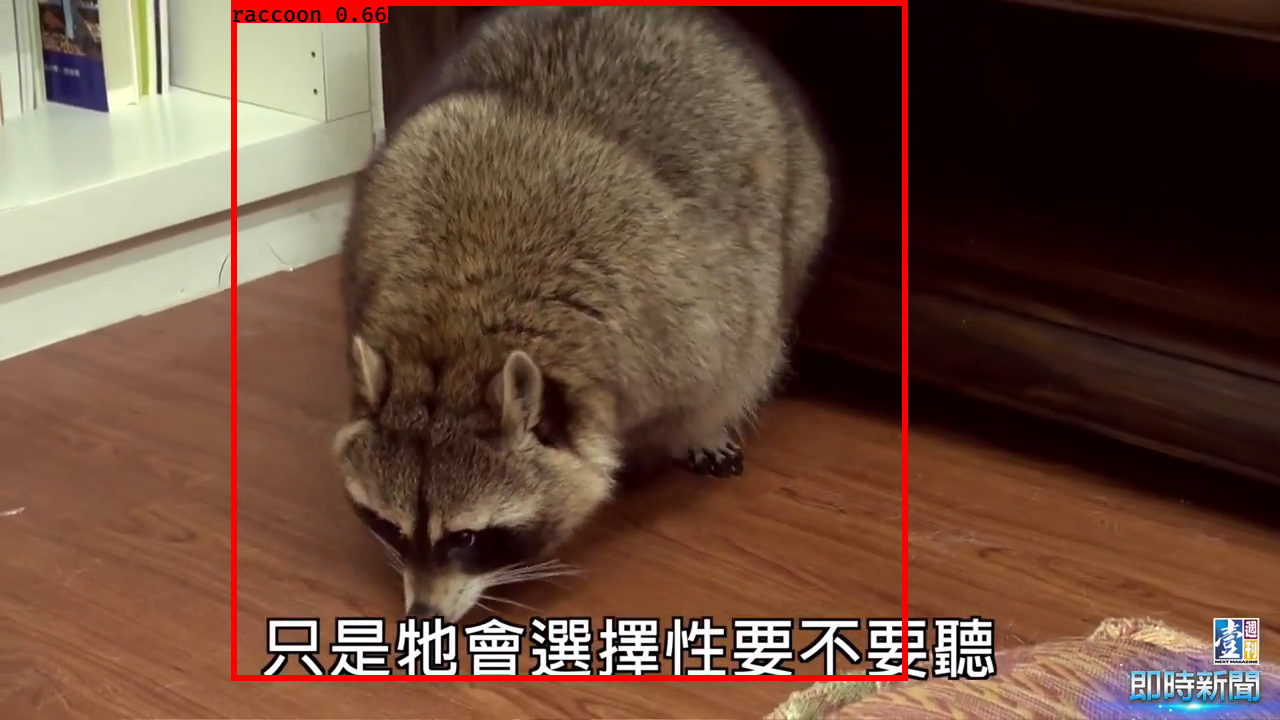

--- ../video_stream/Kangaroo_45s.png ---
(416, 416, 3)
Found 0 boxes for img
0.1979826619999585


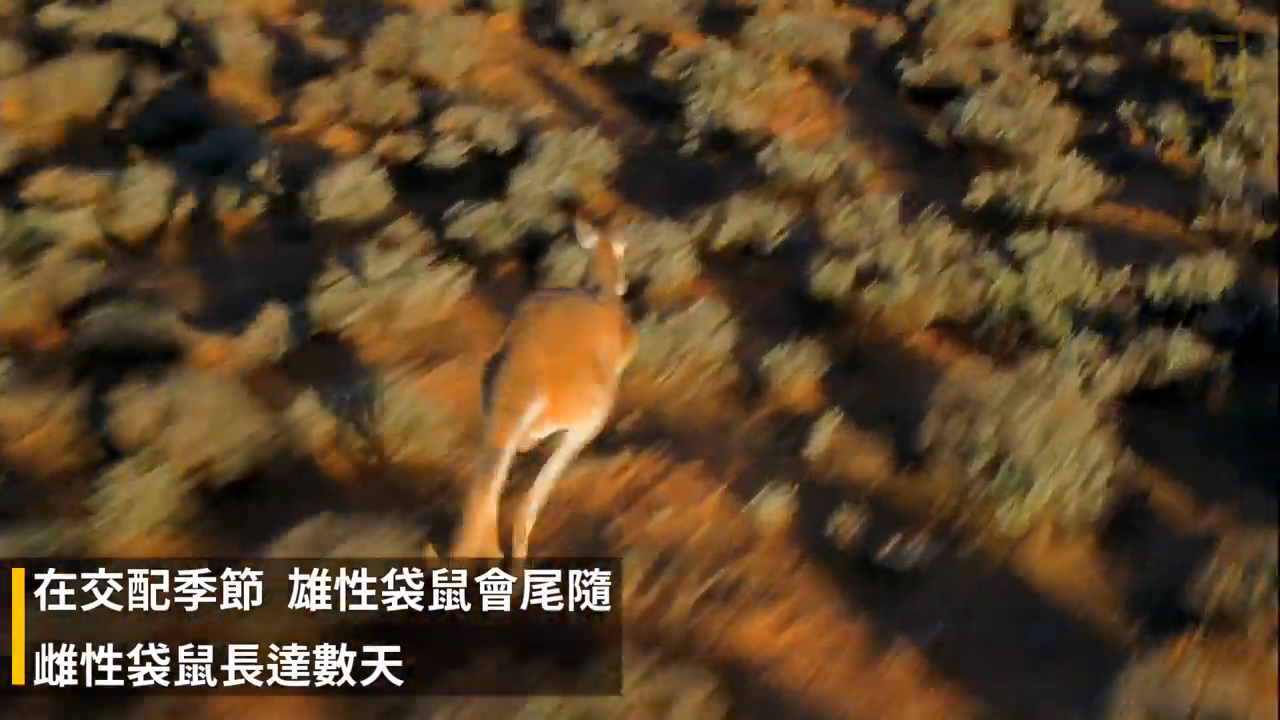

--- ../video_stream/Raccoon_00s.png ---
(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (552, 104) (911, 720)
0.1345970699994723


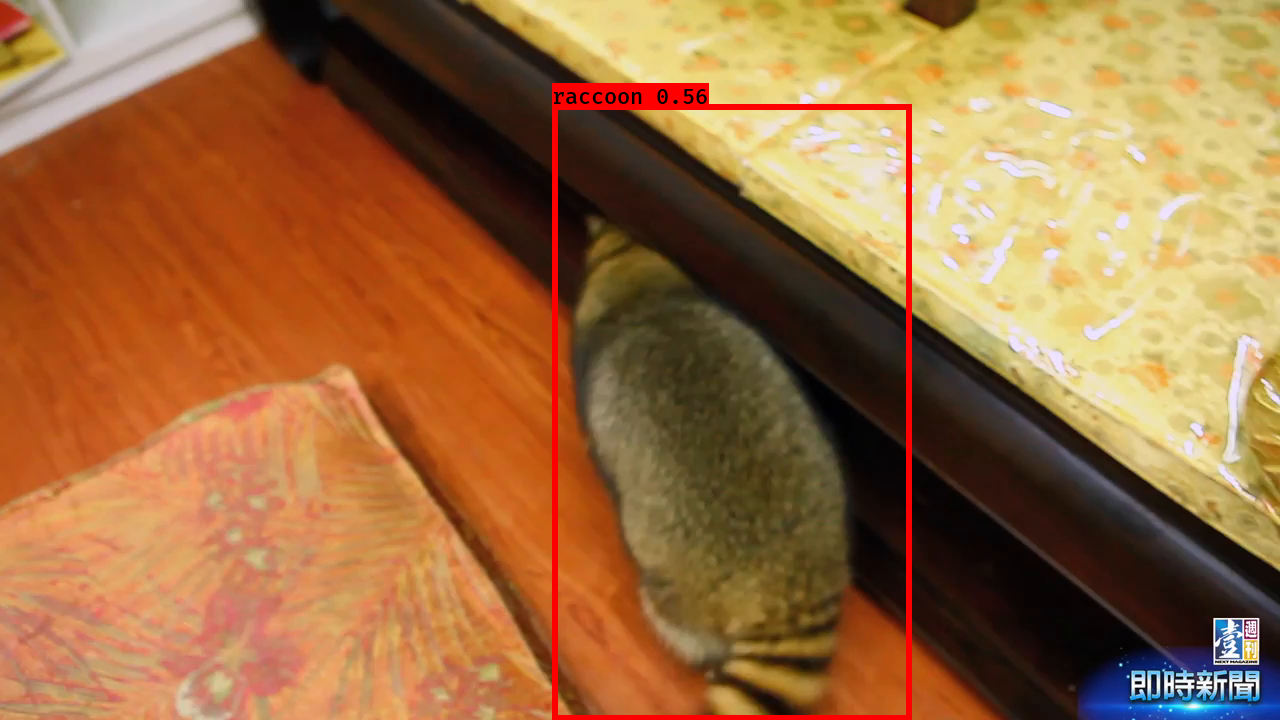

--- ../video_stream/Raccoon_45s.png ---
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (302, 0) (910, 720)
0.1761543630000233


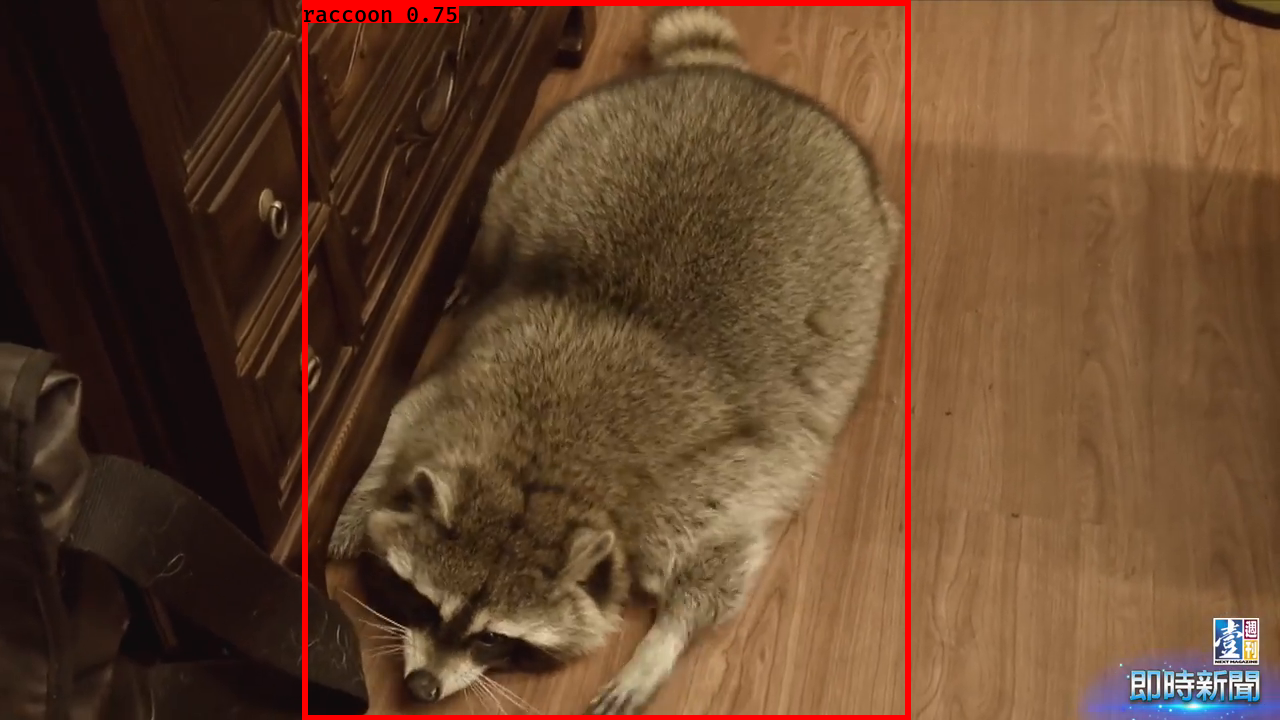

--- ../video_stream/Kangaroo_00s.png ---
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43 (243, 0) (1242, 717)
0.2612553969993314


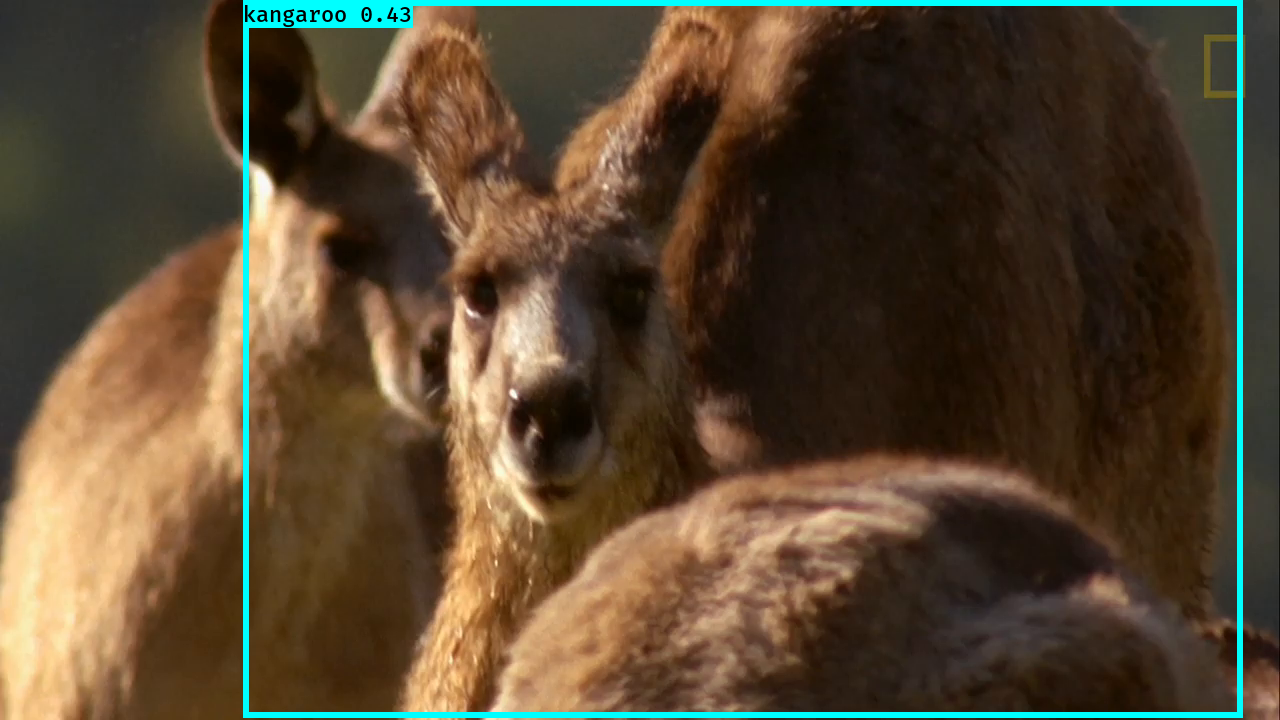

In [35]:
for f in files:  
    image = Image.open(f) 
    print('---', f, '---')
    r_image = yolo_model.detect_image(image)
    display(r_image)